# Add idx to metadata from wandb

In [7]:
import json
import os
import shutil

In [20]:
with open('data/prompt.json', 'r') as f:
    prompt_data = json.load(f)

prompt_to_idx = {item['prompt'].strip().replace('¾', '34'): item['idx'] for item in prompt_data}

In [25]:
data_dir = '/root/siton-data-51d3ce9aba3246f88f64ea65f79d5133/images/grid_times_consistency_plus_subclip_half_wandb'
steps = os.listdir(data_dir)
for step in steps:
    if step == 'media':
        shutil.rmtree(os.path.join(data_dir, step))
        continue
        
    metadata_path = os.path.join(data_dir, step, 'metadata.jsonl')
    with open(metadata_path, 'r') as f:
        metadata = [json.loads(line) for line in f]
    
    for i, item in enumerate(metadata):
        prompt = item['prompt'].strip()
        idx = prompt_to_idx.get(prompt, None)
        if idx is None:
            print(f"Prompt not found: {prompt}")
        else:
            metadata[i] = {
                'idx': idx,
                **item
            }

    with open(metadata_path, 'w') as f:
        for item in metadata:
            f.write(json.dumps(item) + '\n')

# Funcs

In [26]:
def catenate_images(images, captions=None, font_size=16, caption_height=50, layout='horizontal'):
    """
    将图像列表按指定布局排列显示
    
    Args:
        images: PIL Image对象列表
        captions: 可选的图像标题列表
        font_size: 字体大小，默认16
        caption_height: 标题区域高度，默认50
        layout: 布局方式，'horizontal'为水平排列，'grid'为n行2列布局
    
    Returns:
        拼接后的PIL Image对象
    """
    if not images:
        return None
    
    from PIL import ImageDraw, ImageFont
    
    if layout == 'horizontal':
        # 原来的水平布局逻辑
        widths, heights = zip(*(img.size for img in images))
        max_height = max(heights)
        total_width = sum(widths)
        actual_caption_height = caption_height if captions else 0
        
        concatenated = Image.new('RGB', (total_width, max_height + actual_caption_height), 'white')
        
        x_offset = 0
        for i, img in enumerate(images):
            y_offset = (max_height - img.height) // 2
            concatenated.paste(img, (x_offset, y_offset))
            
            if captions and i < len(captions):
                draw = ImageDraw.Draw(concatenated)
                font = _get_font(font_size)
                
                text_bbox = draw.textbbox((0, 0), captions[i], font=font)
                text_width = text_bbox[2] - text_bbox[0]
                text_x = x_offset + (img.width - text_width) // 2
                text_y = max_height + (caption_height - font_size) // 2
                
                draw.text((text_x, text_y), captions[i], fill='black', font=font)
            
            x_offset += img.width
            
    elif layout == 'grid':
        # n行2列布局
        cols = 2
        rows = (len(images) + cols - 1) // cols  # 向上取整
        
        # 获取所有图像的尺寸
        widths, heights = zip(*(img.size for img in images))
        max_width = max(widths)
        max_height = max(heights)
        
        actual_caption_height = caption_height if captions else 0
        
        # 计算总尺寸
        total_width = cols * max_width
        total_height = rows * (max_height + actual_caption_height)
        
        concatenated = Image.new('RGB', (total_width, total_height), 'white')
        
        for i, img in enumerate(images):
            row = i // cols
            col = i % cols
            
            # 计算位置
            x = col * max_width + (max_width - img.width) // 2  # 水平居中
            y = row * (max_height + actual_caption_height) + (max_height - img.height) // 2  # 垂直居中
            
            concatenated.paste(img, (x, y))
            
            # 添加标题
            if captions and i < len(captions):
                draw = ImageDraw.Draw(concatenated)
                font = _get_font(font_size)
                
                text_bbox = draw.textbbox((0, 0), captions[i], font=font)
                text_width = text_bbox[2] - text_bbox[0]
                text_x = col * max_width + (max_width - text_width) // 2
                text_y = row * (max_height + actual_caption_height) + max_height + (actual_caption_height - font_size) // 2
                
                draw.text((text_x, text_y), captions[i], fill='black', font=font)
    
    return concatenated

def _get_font(font_size):
    """获取字体的辅助函数"""
    from PIL import ImageFont
    try:
        font = ImageFont.truetype("arial.ttf", font_size)
    except:
        try:
            font = ImageFont.truetype("DejaVuSans.ttf", font_size)
        except:
            font = ImageFont.load_default()
    return font

# Eval

In [1]:
import json
import os
import numpy as np
import re
from PIL import Image
from collections import defaultdict

with open('data/prompt_consistency_criterion.json', 'r') as f:
    consistency_criterion = json.load(f)

with open('data/prompt.json', 'r') as f:
    prompt_metadata = json.load(f)

    prompt_metadata = {p['idx']: p for p in prompt_metadata}


models = os.listdir('eval_res')
eval_res = {
    model: {} for model in models
}
for model in models:
    res_dirs = os.listdir(f'eval_res/{model}')
    # res_files = list(filter(lambda x: 'flexible' not in x, res_files))
    for dir in res_dirs:
        eval_res[model][dir] = {}
        json_files = [f for f in os.listdir(os.path.join('eval_res', model, dir)) if f.endswith('.jsonl')]
        for file in json_files:
            step = file.replace('.jsonl', '')
            with open(os.path.join('eval_res', model, dir, file), 'r') as f:
                eval_res[model][dir][step] = [json.loads(line) for line in f]


def key_sort_fn(s):
    is_partial = 'half' in s
    has_subclip = 'clip' in s
    has_consistency = 'cons' in s
    has_layout = 'grid' in s
    is_flexible = 'flexible' in s
    all_integers = re.findall(r'\d+', s)
    checkpoint_step = int(all_integers[-1]) if all_integers else -1
    return (
        is_partial,
        has_subclip,
        has_consistency,
        has_layout,
        is_flexible,
        checkpoint_step
    )

In [2]:
aggregate_fn = lambda r: lambda idx, consistency_scores, subfigclip_scores, layout_scores: layout_scores * r * subfigclip_scores + (1 - r) * consistency_scores
agg_fn = aggregate_fn(0.8)
def get_metric_array(data_dict):
    score_names = ['consistency_scores', 'subfigclip_scores', 'layout_scores']
    scores = [[d[sn] for sn in score_names] for idx, d in data_dict.items()]
    return np.array(scores)

In [3]:
eval_res = {
    model:
    {
        label:{
            step:{
                u['idx'] : u for u in v
            }
            for step, v in value.items()
        }
        for label, value in res.items()
    }
    for model, res in eval_res.items()
}

In [4]:
metric_arrays = {
    model: {
        label: {
            step: get_metric_array(data_dict)
            for step, data_dict in res.items()
        }
        for label, res in model_res.items()
    } for model, model_res in eval_res.items()
}

# Line Plot

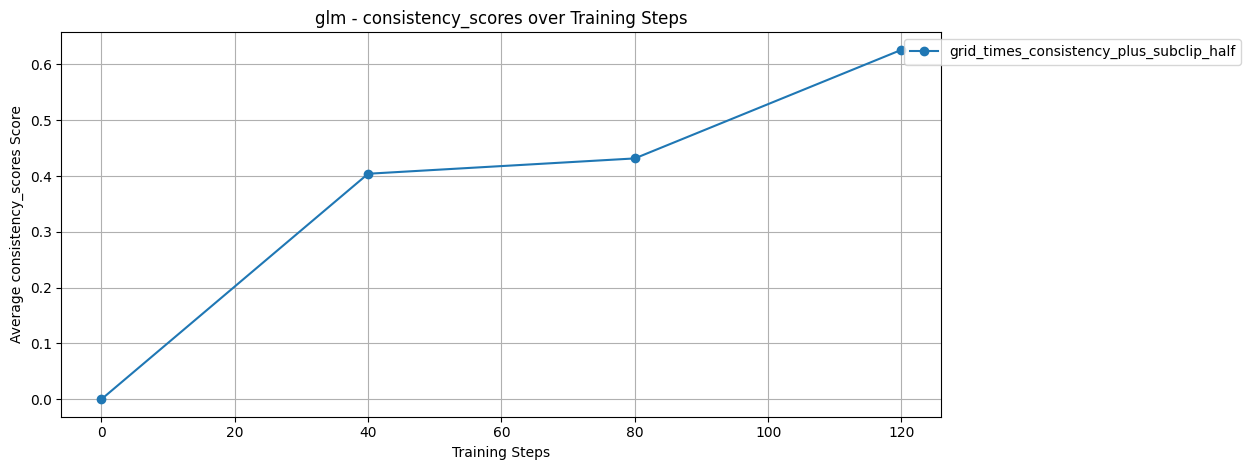

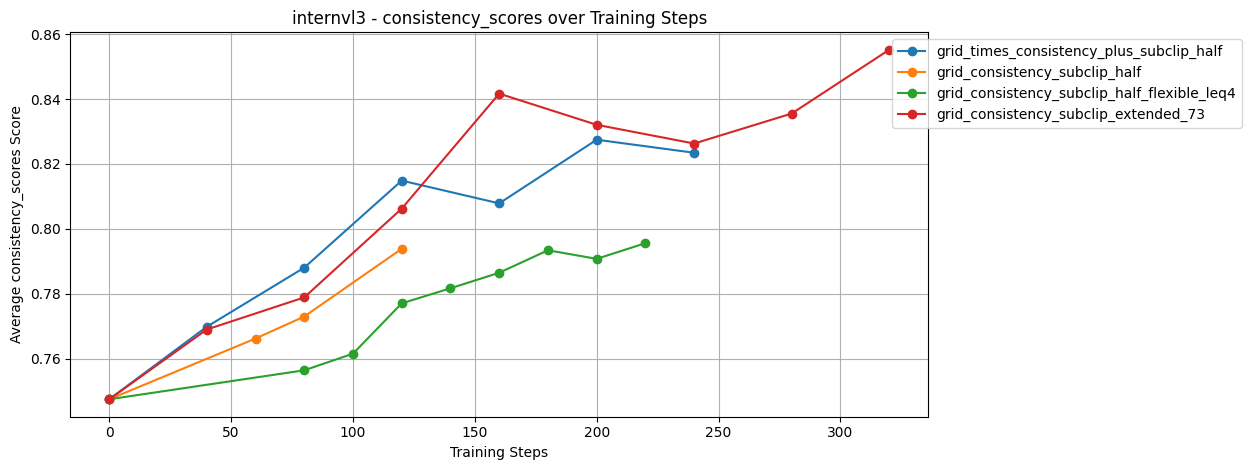

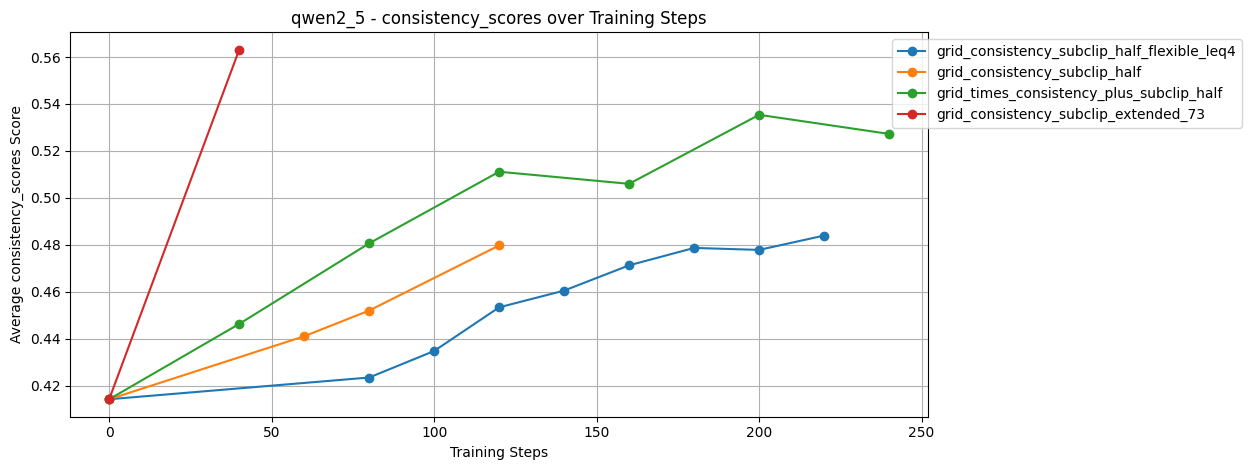

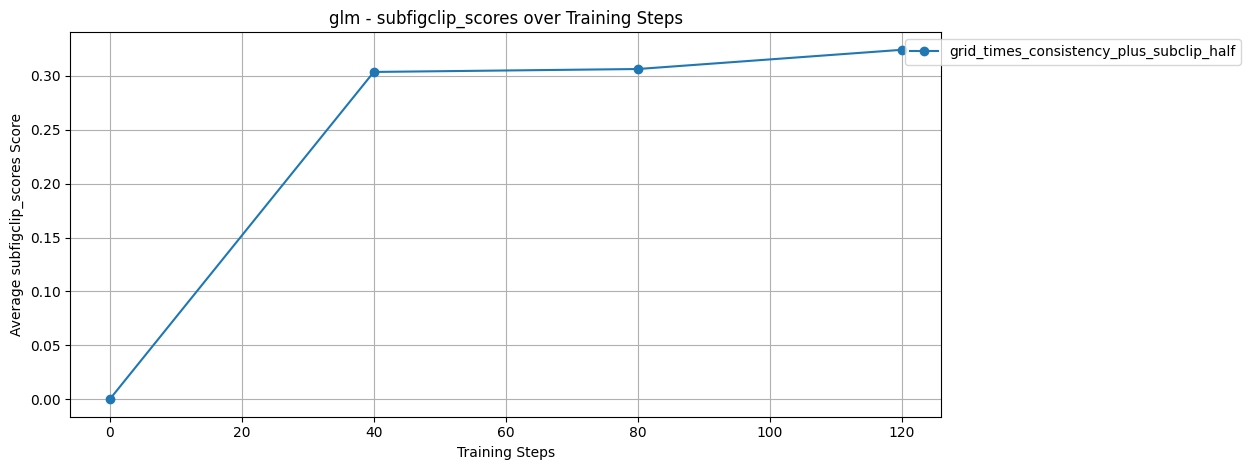

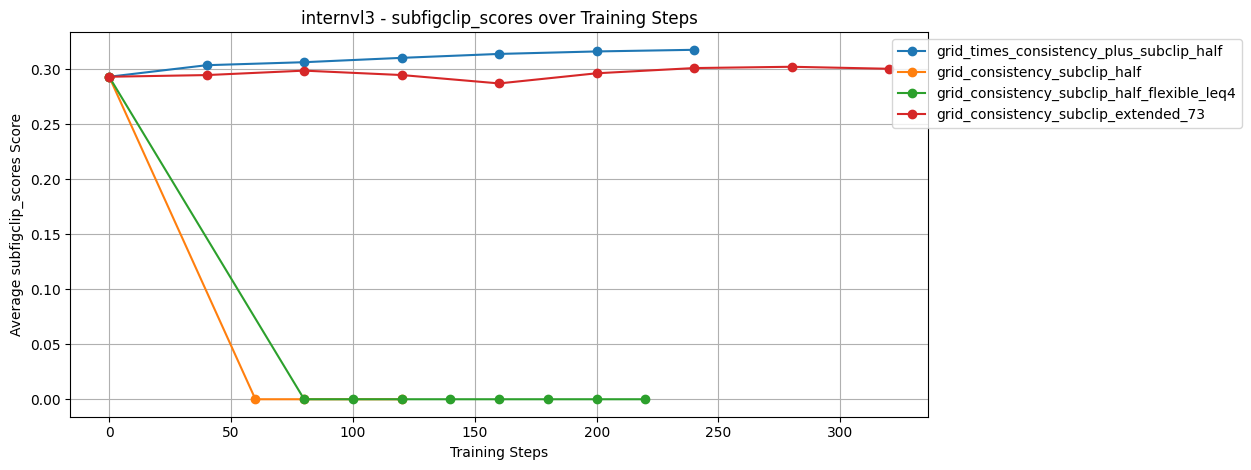

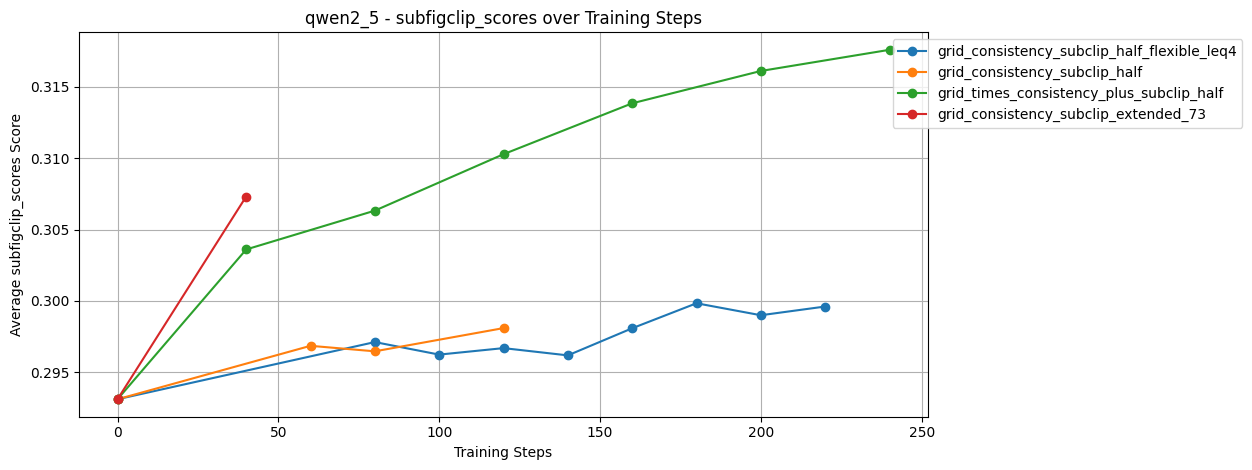

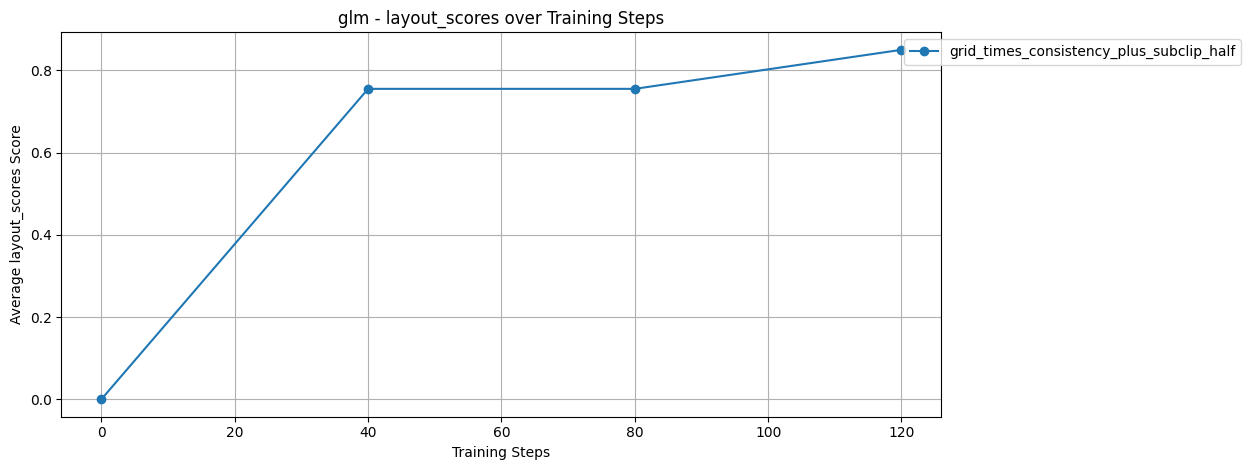

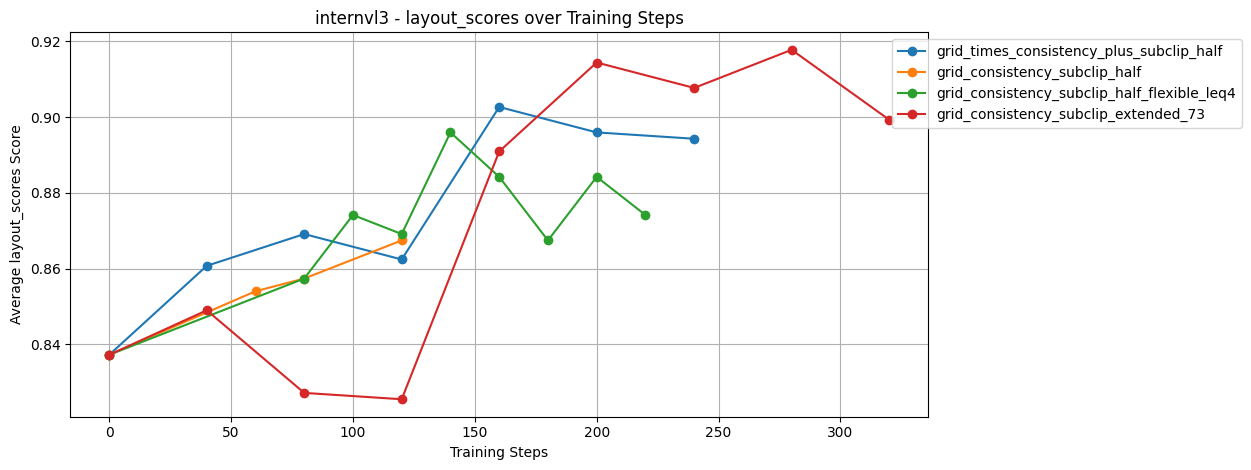

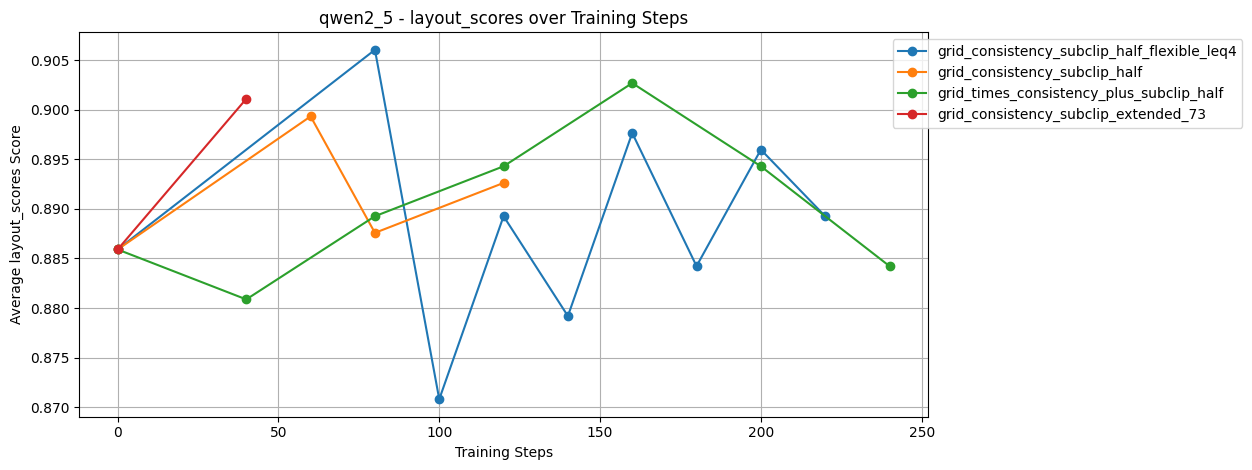

In [7]:
import matplotlib.pyplot as plt
score_names = ['consistency_scores', 'subfigclip_scores', 'layout_scores']
for score in score_names:
    for model in models:
        if 'base' in eval_res[model]:
            base_score = [d[score] for d in eval_res[model]['base']['base'].values()]
        else:
            base_score = [0.0]
        all_labels = [label for label in eval_res[model].keys() if label != 'base' and 'grid' in label]
        for label in all_labels:
            res = eval_res[model][label]
            steps, scores = zip(*sorted(
                ((int(step), np.array([d[score] for d in data_dict.values()]).mean()) for step, data_dict in res.items()),
                key=lambda x: x[0]
            ))
            # Add base score at step 0
            steps = (0,) + steps
            scores = (np.array(base_score).mean(),) + scores
            plt.plot(steps, scores, label=label, marker='o')
    
        plt.xlabel('Training Steps')
        plt.ylabel(f'Average {score} Score')
        plt.title(f'{model} - {score} over Training Steps')
        plt.legend(bbox_to_anchor=(0.95, 1), loc='upper left')
        plt.tight_layout(rect=[0, 0, 2, 1]) # Adjust layout to fit legend
        plt.grid(True)
        # plt.savefig(f'{model}_{score}_over_steps.png')
        plt.show()

# Ranking

In [5]:
common_eval_res = {
    model: {
        k: v for k, v in eval_res[model].items()
        if all(k in eval_res[m] for m in models)
    }
    for model in models
}

In [6]:
# Combine all images to ranking together
all_data = {
    model: [] for model in models
}
for model in models:
    for key, value in common_eval_res[model].items():
        for d in value.values():
            item = d.copy()
            item.update({
                'idx': f"{key}/{d['idx']}",
                'prompt_idx': d['idx'],
            })
            all_data[model].append(item)

In [7]:
def get_common_top_k(model_to_scores: dict[str, dict[str, float]], k=10, sort_key=None, reverse=True):
    k = int(k)
    model_to_scores = {
        model: sorted(scores, key=sort_key, reverse=reverse) if sort_key else sorted(scores, reverse=reverse)
        for model, scores in model_to_scores.items()
    }
    model_to_top_k = {
        model : scores[:k]
        for model, scores in model_to_scores.items()
    }
    common_top_k = list(set.intersection(*[set(d['idx'] for d in scores) for scores in model_to_top_k.values()]))
    return common_top_k

In [8]:
# rank_key = lambda d: d['layout_scores'] * d['consistency_scores']
rank_key = lambda d: d['consistency_scores']
k = 0.1 * len(all_data['qwen'])
print("Select top k", k)
top_k = get_common_top_k(all_data, k=k, sort_key=rank_key)
bottom_k = get_common_top_k(all_data, k=k, sort_key=rank_key, reverse=False)
print("Common top k:", len(top_k), "Common bottom k:", len(bottom_k))

Select top k 774.8000000000001
Common top k: 395 Common bottom k: 434


In [9]:
# count prompt_idx in top_k and bottom_k
from collections import Counter
top_prompt_counter = Counter([idx.split('/')[1] for idx in top_k])
bottom_prompt_counter = Counter([idx.split('/')[1] for idx in bottom_k])
print("Top prompt counter:", top_prompt_counter)
print("Bottom prompt counter:", bottom_prompt_counter)

Top prompt counter: Counter({'0001_0022': 12, '0001_0006': 11, '0004_0005': 11, '0003_0020': 11, '0015_0005': 11, '0005_0006': 11, '0017_0014': 11, '0001_0023': 11, '0015_0001': 10, '0025_0016': 10, '0004_0003': 9, '0005_0019': 9, '0001_0018': 9, '0005_0015': 9, '0002_0013': 9, '0002_0003': 9, '0007_0018': 8, '0007_0016': 8, '0005_0024': 8, '0002_0009': 8, '0005_0010': 7, '0002_0021': 7, '0004_0020': 7, '0002_0011': 7, '0008_0002': 7, '0002_0020': 6, '0003_0019': 6, '0003_0021': 6, '0024_0021': 6, '0004_0017': 6, '0001_0003': 6, '0002_0001': 6, '0001_0021': 5, '0006_0001': 5, '0007_0005': 5, '0009_0019': 5, '0009_0016': 5, '0004_0013': 5, '0005_0007': 5, '0006_0017': 4, '0004_0010': 4, '0007_0012': 4, '0010_0003': 4, '0004_0016': 4, '0008_0010': 4, '0010_0006': 4, '0002_0006': 3, '0010_0009': 3, '0002_0016': 3, '0006_0020': 3, '0023_0015': 3, '0001_0017': 3, '0025_0015': 2, '0009_0002': 2, '0003_0015': 2, '0007_0015': 2, '0007_0019': 2, '0004_0007': 2, '0018_0003': 2, '0022_0023': 2, '

In [126]:
images_dir = '/root/siton-data-51d3ce9aba3246f88f64ea65f79d5133/images'
top_images = defaultdict(list)
bottom_images = defaultdict(list)
for idx in top_k:
    image_idx = idx.split('/')[1]
    top_images[image_idx].append(Image.open(os.path.join(images_dir, f"{idx}.png")))

for idx in bottom_k:
    image_idx = idx.split('/')[1]
    bottom_images[image_idx].append(Image.open(os.path.join(images_dir, f"{idx}.png")))

In [127]:
len(top_images), len(bottom_images)

(83, 97)

In [ ]:
catenate_images(bottom_images['0011_0023'], layout='grid')

In [ ]:
catenate_images(top_images['0007_0016'], layout='grid')